# 2 Gridworld

In [1]:
import numpy as np
import tut_basics as tb

from plot_fxns import plotWorld, plotStateValue, plotStateActionValue, plotPolicyPi, plotGreedyPolicyQ
from rl_agents import RLAgent, RLExampleAgent
import importlib

### 2.0 Build A Gridworld with Random Agent

In [ ]:
# build and plot world
world = tb.GridWorldExample1()
plotWorld(world)

In [ ]:
# initialize an agent and run an episode (see program printout)
agent = RLExampleAgent(world)
tb.run_episode(agent, print_details = False)

In [ ]:
# plot value functions
plotStateValue(agent.v, world)
plotStateActionValue(agent.q, world)

In [ ]:
# plot policy map
plotPolicyPi(agent.Ppi, world)

### 2.1 Dynamic Programming

In [ ]:
# build and plot a new world
world = tb.GridWorldExample2()
plotWorld(world)

In [ ]:
class DP_Agent(RLAgent):
    """Dynamic Programming (DP) agent."""

    def initRandomPolicy(self):
        """
        Build the matrix P_pi = sum_a pi(a|s)*Pr_a(s'|s)
        (See tutorial slides 13-15)"""
        Psum = self.world.P.sum(axis=0)
        Pnorm = Psum.sum(axis=1)
        zero_idxs = Pnorm==0.0
        Pnorm[zero_idxs] = 1.0
        self.P_pi = (Psum.T / Pnorm).T

    def evaluatePolicy(self, gamma):
        delta = 1
        maxiters = 1000  # maximum number of iterations
        itr = 0
        while(delta > 0.001 and itr < maxiters):
            itr += 1
            v_new = self.world.R + gamma * self.P_pi.dot(self.v) # note the policy doesn't appear here! It does in pseudocode. but has already been 'applied' to get P_pi
            delta = np.max(np.abs(v_new - self.v))
            self.v = v_new

    def improvePolicy(self):
        self.P_pi = np.zeros((self.world.nstates,self.world.nstates))
        for s in range(self.world.nstates):
            transitions = np.sum(self.world.P[:,s,:],axis=0).astype(bool)
            nextvals = np.full((self.world.nstates,),-1e6)
            nextvals[transitions] = self.v[transitions]
            s_next = np.argmax(nextvals)
            self.P_pi[s,s_next] = 1

    def policyIteration(self, gamma):
        print("Running policy iteration...")
        policyStable = False
        itr = 0
        maxiters = 1000
        while(not policyStable and itr < maxiters):
            itr += 1
            Ppi_old = self.P_pi
            self.evaluatePolicy(gamma)
            self.improvePolicy()
            policyStable = np.array_equal(Ppi_old,self.P_pi)
        print("Converged after %d iterations." % itr)


In [ ]:
agent = DP_Agent(world)
# set your discount factor
gamma = 0.99
# initialize agent with random policy
agent.initRandomPolicy()
# do policy evaluation and improvment
agent.policyIteration(gamma)

In [ ]:
# plot value function
plotStateValue(agent.v, world)
# plot policy map
plotPolicyPi(agent.P_pi, world)

### 2.2 Temporal Difference Learning

In [3]:
class TDSarsa_Agent(RLAgent):
    def __init__(self, world):
        super(TDSarsa_Agent, self).__init__(world)
        self.policy = self.epsilongreedyQPolicy

    def evaluatePolicyQ(self, gamma, alpha, ntrials):
        delta = 1.0
        old_q = self.q
        for i in range(ntrials):
            is_terminal = False
            c = 0
            self.reset()
            s = self.state
            a = self.choose_action()
            while not is_terminal:
                c += 1
                is_terminal = self.take_action(a)
                a_prime = self.choose_action() if not is_terminal else 'D'
                self.q[s,self.action_dict[a]] += alpha*(self.reward + gamma*self.q[self.state,self.action_dict[a_prime]] - self.q[s,self.action_dict[a]])
                s = self.state
                a = a_prime
            delta = min(np.max(np.abs(self.q - old_q)),delta)
            old_q = self.q

    def policyIteration(self, gamma, alpha, ntrials):
        print("Running TD policy iteration...")
        policyStable = False
        itr = 0
        maxiters = 1000 # catch the while loop.
        oldA = np.zeros((self.world.nstates,))
        while (not policyStable and itr < maxiters):
            itr += 1
            self.evaluatePolicyQ(gamma, alpha, ntrials)   
            policyStable = np.array_equal(oldA,np.argmax(self.q, axis=1)) # see if policy changes!
            oldA = np.argmax(self.q, axis=1)
        print("Converged after {} iterations.".format(itr))

Running TD policy iteration...
Converged after 2 iterations.


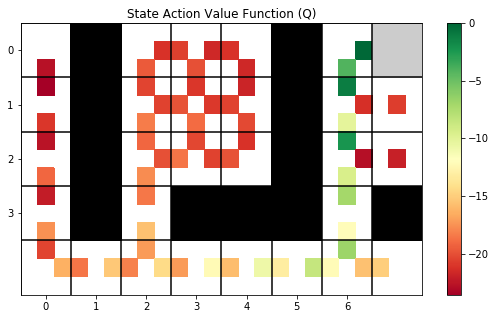

In [6]:
world = tb.GridWorldExample3()
agent = TDSarsa_Agent(world)

gamma = 0.99
alpha = 0.2
ntrials = 500
agent.evaluatePolicyQ(gamma, alpha, ntrials)
agent.policyIteration(gamma, alpha, ntrials)

plotStateActionValue(agent.q,world)

### 2.3 Off-Policy Temporal Difference (TD) -- Q Learning

Here you will compare Q learning with SARSA from above. Which one is better, and why? Plot the Q-values and policies for the two. Run 100 episodes of each after learning, and compare average total return for each episode. Which algorithm receives more reward on average? 

In [ ]:
class TDQ_Agent(TDSarsa_Agent):
    def __init__(self, world):
        super(TDQ_Agent, self).__init__(world)
        self.policy = self.epsilongreedyQPolicy
        self.offpolicy = self.greedyQPolicy

    def choose_offpolicy_action(self):
        state = self.world.get_state()
        actions = self.world.get_actions()
        self.action = self.offpolicy(state, actions)
        return self.action

    def evaluatePolicyQ(self, gamma, alpha, ntrials):
        delta = 1.0
        old_q = self.q
        for i in range(ntrials):
            is_terminal = False
            c = 0
            self.reset()
            s = self.state
            a = self.choose_action()
            while not is_terminal:
                c += 1
                is_terminal = self.take_action(a) # taking an action gives terminality status.
           # explore from the epsilon-greedy policy 
                a_prime = self.choose_action() if not is_terminal else 'D'
           # below we choose a prime from the TRUE policy! 
                a_greedy = self.choose_offpolicy_action() if not is_terminal else 'D'
                self.q[s,self.action_dict[a]] += alpha*(self.reward + gamma*self.q[self.state,self.action_dict[a_greedy]] - self.q[s,self.action_dict[a]])
                s = self.state
                a = a_prime
            delta = min(np.max(np.abs(self.q - old_q)),delta)
            old_q = self.q
        
    def policyIteration(self, gamma, alpha, ntrials):
        print("Running TD policy iteration...")
        policyStable = False
        itr = 0
        maxiters = 1000 # catch the while loop.
        oldA = np.zeros((self.world.nstates,))
        while (not policyStable and itr < maxiters):
            itr += 1
            self.evaluatePolicyQ(gamma, alpha, ntrials)   
            policyStable = np.array_equal(oldA,np.argmax(self.q, axis=1)) # see if policy changes!
            oldA = np.argmax(self.q, axis=1)
        print("Converged after {} iterations.".format(itr))
    

In [ ]:
from tut_basics import CliffWorld
world = CliffWorld()
# test Q Agent 
q_agent = TDQ_Agent(world)
alpha = 0.05
ntrials = 2000
gamma = 0.9
q_agent.policyIteration(gamma, alpha, ntrials)
plotStateActionValue(q_agent.q,world)
plotGreedyPolicyQ(q_agent.q,world)

In [ ]:
# compare control with Q learner against control with SARSA
world = CliffWorld()
sarsa_agent = TDSarsa_Agent(world)
alpha = 0.2
ntrials = 2000
gamma = 0.9
sarsa_agent.policyIteration(gamma, alpha, ntrials)
plotStateActionValue(sarsa_agent.q,world)
plotGreedyPolicyQ(sarsa_agent.q,world)

### 2.4 TD Lambda 

In [4]:
class TDSarsaLambda_Agent(TDSarsa_Agent):
    def __init__(self, world, lamb):
        super(TDSarsaLambda_Agent, self).__init__(world)
        self.policy = self.epsilongreedyQPolicy
        self.lamb = lamb

    def evaluatePolicyQ(self, gamma, alpha, ntrials):
        delta = 1.0
        old_q = self.q
        eligibility = np.zeros((self.world.nstates,5)) #  store elig traces
        for i in range(ntrials):
            is_terminal = False
            c = 0
            self.reset()
            s = self.state
            a = self.choose_action()
            while not is_terminal:
                c += 1
                is_terminal = self.take_action(a) # this updates other stuff and returs terminality
                a_prime = self.choose_action() if not is_terminal else 'D'
                delta = self.reward + gamma*self.q[self.state,self.action_dict[a_prime]] - self.q[s,self.action_dict[a]]
                eligibility[s,self.action_dict[a]] += 1.0
                self.q[s,self.action_dict[a]] += alpha*(self.reward + gamma*self.q[self.state,self.action_dict[a_prime]] - self.q[s,self.action_dict[a]])
                for s in range(self.world.nstates):
                    for a in range(5):
                        self.q[s,a] += alpha*delta*eligibility[s,a]
                        eligibility[s,a] *= gamma*self.lamb
                        s = self.state
                        a = a_prime
                        delta = min(np.max(np.abs(self.q - old_q)),delta)
                        old_q = self.q

In [9]:
from tut_basics import GridWorldExample2

world = GridWorldExample2()

# 1. test policy evaluation for one trial (episode)
lamb = 0.9
agent = TDSarsaLambda_Agent(world, lamb)
alpha = 0.05
ntrials = 1
gamma = 0.9
agent.evaluatePolicyQ(gamma, alpha, ntrials)
plotStateActionValue(agent.q,world)

sarsa0_agent = TDSarsa_Agent(world)
sarsa0_agent.evaluatePolicyQ(gamma, alpha, ntrials)
plotStateActionValue(sarsa0_agent.q,world)

KeyboardInterrupt: 

In [ ]:
# 2. do policy iteration
ntrials = 10
agent.policyIteration(gamma, alpha, ntrials)
plotStateActionValue(agent.q,world)
plotGreedyPolicyQ(agent.q,world)

sarsa0_agent.policyIteration(gamma, alpha, ntrials)
plotStateActionValue(sarsa0_agent.q,world)
plotGreedyPolicyQ(agent.q,world)